# Benchmarking notebook

This notebook contains all of the methods and analysis for performing benchmarking

# Imports and dependencies

In [1]:
import os
import glob
from pathlib import Path
from enum import Enum
import numpy as np
from dataclasses import dataclass
from typing import List, Dict
import matplotlib.pyplot as plt
import pickle
import json

# Notebook parameters
These parameters are used throughout the notebook for benchmarking. These parameters include paths, tuning, and other various parameter settings.

In [2]:
file_with_names = "./abundance.tsv"
accession2taxid_file = "../../database/krakenDB/taxonomy/nucl_gb.accession2taxid"
reference_genomes_dir = ""
results_dir = ""


In [3]:
# read in the NCBI to Tax id namings
with open('out_dictionary.txt') as f:
    dictionary_str = f.read()
dictionary = json.loads(dictionary_str)

### create mapping dictionary (don't need to run, done offline and included)
This step is time consuminig so better done offline

**NOTE**: This is skipped assuming the above works

In [4]:
def get_needed_ncbi_ids():
    """
    gets NCBI ids
    """
    file_with_names_opened = open(file_with_names)
    
    # grab all needed NCBI ids
    ncbi_ids = []
    line = file_with_names_opened.readline()
    line_counter = 0
    while(line):
        if (line_counter > 0): # skip header
            ncbi_id = line.split("\t")[0]
            ncbi_ids.append(ncbi_id)
        line = file_with_names_opened.readline()
        line_counter += 1
        
    file_with_names_opened.close()
    
    return ncbi_ids

In [5]:
def create_mapping_dictionary():
    """
    Creates dictionary for mapping NCBI ids to 
    taxonomy.
    
    Uses nucl_gb.accession2taxid
    
    NC_033618	NC_033618.1	1931113	1139918407
    """
    dictionary = {}

    # grab taxid mappings
    acc2tax_open = open(accession2taxid_file)
    line = acc2tax_open.readline()
    counter = 0
    while(line):
        line = acc2tax_open.readline()
        line = line.split("\t")
        accession = line[1]
        taxid = line[2]
        if accession in ncbi_ids:
            dictionary[accession] = taxid
        if (len(dictionary.keys()) == len(ncbi_ids)):
            break
        counter += 1
        
        if (counter % 100000 == 0):
            print(f"{counter} lines have been parsed \n")
    acc2tax_open.close()

    return dictionary

if not dictionary:
    ncbi_ids = get_needed_ncbi_ids()
    dictionary = create_mapping_dictionary()

# Parsers
These methods are used for parsing all of the tools being benchmarked. These parsers are passed to a general parser function, giving a strategy-pattern-like method for obtaining result from tools.

In [41]:
def parser_enrichseq(debExt_dir: Path, delim=","):
    """
    This function parses the enrichseq output directory.
    OUTPUT:
        1. taxid abundances
        abundances_dict = {'tax_id_1' : 33,
                           'tax_id_2' : 33,
                           ...,
                           'tax_id_N' : 33,
                          }
        2. cluster abundances
        abundances_dict = {'cluster_1' : 33,
                           'cluster_2' : 33,
                           ...,
                           'cluster_M' : 33,
                          }
    """
    # init datastructures
    abundances = {"taxid_abundance" : {},
                  "cluster_abundance" : {}} # <tax/clust>id : abundance
    # get paths
    output_path = debExt_dir / Path('enrichseq/output_files/')
    taxid_abundances = output_path / Path('taxid_abundances.csv')
    cluster_abundances = output_path / Path('cluster_abundances.csv')
    # parse abundance CSVs
    csvs_to_parse = {"taxid_abundance" : taxid_abundances, 
                     "cluster_abundance" : cluster_abundances}
    for csv_name, csv_file in csvs_to_parse.items():
        with open(csv_file, "r") as csv_file_opened:
            csv_file_lines = csv_file_opened.readlines() # never that big, read all into RAM
            for line in csv_file_lines:
                tax_clust_id, abundance_val = line.strip("\n").split(delim)
                abundances[csv_name][tax_clust_id] = float(abundance_val)

    return abundances

def parser_fastviromeexplorer(directory, name_column=0, counts_column=3, delim="\t"):
    """
    This function parses the enrichseq output directory.
    OUTPUT:
        1. taxid abundances
        abundances_dict = {'tax_id_1' : 33,
                           'tax_id_2' : 33,
                           ...,
                           'tax_id_N' : 33,
                          }
        2. cluster abundances
        abundances_dict = {'cluster_1' : 33,
                           'cluster_2' : 33,
                           ...,
                           'cluster_M' : 33,
                          }
    """
    # init datastructures
    abundances = {"taxid_abundance" : {}} # <tax/clust>id : abundance
    # get paths
    taxid_abundances = directory / Path('abundance.tsv')
    # parse abundance CSVs
    csvs_to_parse = {"taxid_abundance" : taxid_abundances}
    total_abundance = 0
    for csv_name, csv_file in csvs_to_parse.items():
        with open(csv_file, "r") as csv_file_opened:
            csv_file_lines = csv_file_opened.readlines() # never that big, read all into RAM
            for line_ind, line in enumerate(csv_file_lines):
                if line_ind > 0: # skip header
                    ncbi_id = line.strip("\n").split(delim)[name_column]
                    counts_val = line.strip("\n").split(delim)[counts_column]

                    # convert NCBI name to taxid, save counts
                    try:
                        tax_clust_id = dictionary[ncbi_id] # 'dictionary' imported above
                    except:
                        tax_clust_id = 'unk'
                    abundances[csv_name][tax_clust_id] = float(counts_val)
                    total_abundance += float(counts_val)
    
    # update abundances dictionary
    ids_to_del = []
    for tax_id, abundance_val in abundances["taxid_abundance"].items():
        if total_abundance > 0:
            abundances["taxid_abundance"][tax_id] /= total_abundance #normalize
        if abundances["taxid_abundance"][tax_id] < 0.001:
            ids_to_del.append(tax_id)
    # delete 0 value taxids
    for val in ids_to_del:
        del abundances["taxid_abundance"][val]

    return abundances


def parse_simulated_fasta(fasta_path):
    """
    Parses simulated file for true abundances
    """
    abundances = {'taxid_abundance' : {}}
    total_counts = 0
    with open(fasta_path, "r") as fasta_opened:
        line = fasta_opened.readline()
        while (line):
            if (line[0] == ">"):
                try:
                    name = dictionary[line[1:].split("|")[0].split("-")[0]]
                except:
                    name = "unk"
                if name in abundances['taxid_abundance']:
                    abundances['taxid_abundance'][name] += 1
                else:
                    abundances['taxid_abundance'][name] = 1
                total_counts += 1
                if (total_counts % 1000000 == 0):
                    print(f"{total_counts} lines parsed")
            line = fasta_opened.readline()
            
    #turn counts into abundances
    for tax_id in abundances['taxid_abundance'].keys():
        abundances['taxid_abundance'][tax_id] /= total_counts #normalize
    return abundances

In [42]:
# testing parsing functions
fastvirome_values = parser_fastviromeexplorer("//scratch/summit/dral3008/benchmarking_enrichseq/results/FastViromeExplorer/num_mutations_test/3_genomes_sim_05del_05ins_illumina/")
enrichseq_values = parser_enrichseq("//scratch/summit/dral3008/benchmarking_enrichseq/results/enrichseq/num_mutations_test/3_genomes_sim_00del_05ins_illumina./")
true_values = parse_simulated_fasta("//scratch/summit/dral3008/benchmarking_enrichseq/tests/num_mutations_test/3_genomes_sim_05del_05ins_illumina.fa")
print(fastvirome_values)
print(enrichseq_values)
print(true_values)

{'taxid_abundance': {'2681618': 0.32963232138684007, '10868': 0.3339167091819126, '2886930': 0.3310543089373423}}
{'taxid_abundance': {'2886930': 0.32134713471347137, 'UNK': 0.03574157415741574, '10868': 0.3215941594159416, '2681618': 0.32131713171317133}, 'cluster_abundance': {'C_2': 0.32134713471347137, 'UNK': 0.03574157415741574, 'C_1': 0.3215941594159416, 'C_3': 0.32131713171317133}}
{'taxid_abundance': {'2886930': 0.3333333333333333, '10868': 0.3333333333333333, '2681618': 0.3333333333333333}}


# Results Methods and structures
The methods and data structures here are used for creating a common data structure for the output of all tools being compared with one another. 

In [60]:
class ResultStruct:
    """ EnrichSeq - datastruct for holding results """
    
    def __init__(self):
        self.l2_abundance_distance = []
        self.classification_recall = 0
        self.classification_precision = 0

In [77]:
PARSERS_MAP = {"enrichseq" : parser_enrichseq,
               "FastViromeExplorer" : parser_fastviromeexplorer
              }
def parse_dir(results_directory, test_directory):
    """
    This function parses all files within an output
    folder for DebruijnExtend.

    OUTPUT:                                                                     
        {
            test_1 : {
                        enrichseq : ResultStruct,
                        tool_1 : ResultStruct,
                        ...
                        tool_N : ResultStruct,
                     }
            ...
            test_M : {
                        enrichseq : ResultStruct,
                        tool_1 : ResultStruct,
                        ...
                        tool_N : ResultStruct,
                     }
        }
    """
    results = {}
    # parse truth
    for test_directory_name in os.listdir(test_directory):
        test_full_path = Path(test_directory) / Path(test_directory_name)
        if os.path.isdir(test_full_path): # if directory
            # create sub dictionary if not exists
            if test_directory_name not in results:
                results[test_directory_name] = {}
                
            # loop through all fasta files and parse for true abundance
            for file_test in os.listdir(test_full_path):
                file_full_path = Path(test_full_path) / Path(file_test)
                if os.path.isfile(file_full_path) and (file_full_path.suffix == ".fa"): # if file and fasta
                    #file_test = file_test.strip(".fa")
                    # create subsub dictionary if not exists
                    if file_test not in results[test_directory_name]:
                        file_test = file_test.replace(".fa", "")
                        results[test_directory_name][file_test] = {}
                        
                    # add abundances to results
                    abundances = parse_simulated_fasta(file_full_path)
                    results[test_directory_name][file_test]["true"] = abundances

    # parse results
    for tool_name in os.listdir(results_directory):
        results_path = Path(results_directory) / Path(tool_name)
        for test_directory_name in os.listdir(results_path):
            test_full_path = Path(results_path) / Path(test_directory_name)
            if os.path.isdir(test_full_path): # if directory
                # loop through all fasta files and parse for true abundance
                for file_test in os.listdir(test_full_path):
                    file_full_path = Path(test_full_path) / Path(file_test)
                    if os.path.isdir(file_full_path): # is results dir
                        # add abundances to results
                        try:
                            abundances = PARSERS_MAP[tool_name](file_full_path)
                            results[test_directory_name][file_test.strip(".")][tool_name] = abundances
                        except:
                            print(f"{tool_name} is missing {file_test} from {test_directory_name}")
                            continue
    # create results 
    for test_name in results.keys():
        for sub_test in results[test_name].keys():
            for tool_name, result_val in results[test_name][sub_test].items():
                print(f"{test_name}, {sub_test}, {tool_name}")
                if tool_name != "true":
                    results_out = get_results(results[test_name][sub_test][tool_name], 
                                              results[test_name][sub_test]["true"])
                    results[test_name][sub_test][tool_name] = results_out
            del results[test_name][sub_test]["true"]
    
    return results
    
def get_results(predicted_results, true_results):
    """
    returns ResultStruct per tool using
    the parsed output directories/files.
    """
    #init
    results_structure = ResultStruct()
    predicted_abundances = predicted_results['taxid_abundance']
    true_abundances = true_results['taxid_abundance']
    
    # error handling
    if (len(true_abundances) == 0): 
        print(f"TRUTH EMPTY")
        return results_structure
    # classification results
    ## true positives
    true_positives = []
    for pred_taxid in predicted_abundances.keys():
        if pred_taxid in true_abundances.keys():
            true_positives.append(pred_taxid)
    ## false positives
    false_positives = []
    for pred_taxid in predicted_abundances.keys():
        if pred_taxid not in true_abundances.keys():
            false_positives.append(pred_taxid)
    ## false negatives
    false_negatives = []
    for pred_taxid in true_abundances.keys():
        if pred_taxid not in predicted_abundances.keys():
            false_negatives.append(pred_taxid)
    ## get metrics
    print(f"predicted_abundances = {predicted_abundances}, true abundaces = {true_abundances}")
    recall = len(true_positives) / (len(true_positives) + len(false_negatives))
    precision = len(true_positives) / (len(true_positives) + len(false_positives))
    print(f"recall : {recall} | precision : {precision}")
    
    
    # abundance results
    ## L2 distances
    l2_dist_array = []
    for tax_id, pred_abundance in predicted_abundances.items():
        if tax_id in true_abundances:
            l2_diff = abs(pred_abundance - true_abundances[tax_id])
        else:
            l2_diff = 0
        l2_dist_array.append(l2_diff)
    print(l2_dist_array)
    
    # store into results structure
    results_structure.l2_abundance_distance = l2_dist_array
    results_structure.classification_recall = recall
    results_structure.classification_precision = precision
    
    return results_structure

In [78]:
results = parse_dir("//scratch/summit/dral3008/benchmarking_enrichseq/results/",
                    "//scratch/summit/dral3008/benchmarking_enrichseq/tests/")

1000000 lines parsed
1000000 lines parsed
1000000 lines parsed
1000000 lines parsed
1000000 lines parsed
1000000 lines parsed
1000000 lines parsed
2000000 lines parsed
3000000 lines parsed
4000000 lines parsed
1000000 lines parsed
1000000 lines parsed
2000000 lines parsed
3000000 lines parsed
4000000 lines parsed
5000000 lines parsed
6000000 lines parsed
7000000 lines parsed
8000000 lines parsed
9000000 lines parsed
1000000 lines parsed
1000000 lines parsed
1000000 lines parsed
enrichseq is missing 3_genomes_sim_3000000_illumina. from num_reads_test
num_genomes_test, 5_genomes_sim_illumina, true
num_genomes_test, 5_genomes_sim_illumina, enrichseq
predicted_abundances = {'2886930': 0.198551, 'UNK': 0.007351, '10868': 0.198515, '2681618': 0.198531, '10658': 0.198537, '127507': 0.198515}, true abundaces = {'2886930': 0.2, '10868': 0.2, '2681618': 0.2, '10658': 0.2, '127507': 0.2}
recall : 1.0 | precision : 0.8333333333333334
[0.0014490000000000058, 0, 0.001485000000000014, 0.0014689999999

In [79]:

print(results)

{'num_genomes_test': {'5_genomes_sim_illumina': {'enrichseq': <__main__.ResultStruct object at 0x2b27ef85fbe0>}, '1_genomes_sim_illumina': {'enrichseq': <__main__.ResultStruct object at 0x2b27f6177630>}, '3_genomes_sim_illumina': {'enrichseq': <__main__.ResultStruct object at 0x2b27f6168cc0>}, '10_genomes_sim_illumina': {'enrichseq': <__main__.ResultStruct object at 0x2b27f61c3eb8>}, '1000_genomes_sim_illumina': {'enrichseq': <__main__.ResultStruct object at 0x2b27f61775f8>}, '100_genomes_sim_illumina': {'enrichseq': <__main__.ResultStruct object at 0x2b27f6168fd0>}}, 'num_mutations_test': {'3_genomes_sim_00del_05ins_illumina': {'FastViromeExplorer': <__main__.ResultStruct object at 0x2b27f6177fd0>, 'enrichseq': <__main__.ResultStruct object at 0x2b27f6177f98>}, '3_genomes_sim_05del_05ins_illumina': {'FastViromeExplorer': <__main__.ResultStruct object at 0x2b27f6177f28>, 'enrichseq': <__main__.ResultStruct object at 0x2b27f6177f60>}, '3_genomes_sim_05del_0ins_illumina': {'FastViromeExp

# Plotting Methods
These methods use the common `ResultStruct` datastructure (or arry thereof) for plotting individual tool metrics. 

In [178]:
def plot_violin(input_results, test, metric='classification'):                                                        
    """                                                                         
    This function plots a bar plot output for a given test set and value
    """ 
    
    width = 0.35
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    if (metric == 'classification'):
        sub_results = input_results[test]
        x_tick_names = [[], []]
        x_tick_arr = []
        index_map = {'enrichseq' : 0, 'FastViromeExplorer' : 1}
        for subtest_name in sub_results.keys():
            x_tick_arr.append(" ".join(subtest_name.split("_")))
            for tool, results_struct in sub_results[subtest_name].items():
                f1_score = 2 * (results_struct.classification_recall * results_struct.classification_precision) 
                if ((results_struct.classification_recall != 0) or
                    (results_struct.classification_precision != 0)):
                    f1_score /= (results_struct.classification_recall + results_struct.classification_precision) 
                x_tick_names[index_map[tool]].append(f1_score)
                
        # make plot
        ind = np.arange(len(x_tick_names[0]))
        print(ind)
        ax.bar(ind, x_tick_names[index_map['enrichseq']], color='r', width = 0.30)
        if (len(x_tick_names[0]) == len(x_tick_names[1])):
            ax.bar(ind + 0.30, x_tick_names[index_map['FastViromeExplorer']], width = 0.30, color='b')
        ax.legend(labels=['enrichseq', 'FastViromeExplorer'])
        ax.set_xticks(ind)
        ax.set_xticklabels(x_tick_arr, rotation=45)
        ax.set_title(f"Testing the impact of {test} \n {metric}-focused", size=15)
        ax.set_ylabel("F1 score", size=15)
        ax.set_xlabel("Sub test", size=15)
        
        
    elif (metric == 'abundance'):
        sub_results = input_results[test]
        x_tick_names = [[], []]
        x_tick_arr = []
        index_map = {'enrichseq' : 0, 'FastViromeExplorer' : 1}
        for subtest_name in sub_results.keys():
            x_tick_arr.append(" ".join(subtest_name.split("_")))
            for tool, results_struct in sub_results[subtest_name].items():
                l2_avg = np.average(results_struct.l2_abundance_distance)
                x_tick_names[index_map[tool]].append(l2_avg)
                
        # make plot
        ind = np.arange(len(x_tick_names[0]))
        print(ind)
        ax.bar(ind, x_tick_names[index_map['enrichseq']], color='r', width = 0.30)
        if (len(x_tick_names[0]) == len(x_tick_names[1])):
            ax.bar(ind + 0.30, x_tick_names[index_map['FastViromeExplorer']], width = 0.30, color='b')
        ax.legend(labels=['enrichseq', 'FastViromeExplorer'])
        ax.set_xticks(ind)
        ax.set_xticklabels(x_tick_arr, rotation=45)
        ax.set_title(f"Testing the impact of {test} \n {metric}-focused", size=15)
        ax.set_ylabel("L2 distance", size=15)
        ax.set_xlabel("Sub test", size=15)
    else:
        print(f"Metric of type {metric} is not known")
    plt.show()

# Benchmarking
This section splits the various benchmarking sections into a clear, concise set of scripts.

### Number of genomes comparison

[0 1 2 3 4 5]


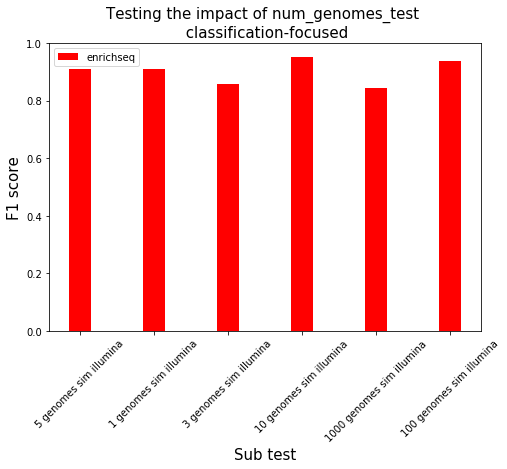

[0 1 2 3 4 5]


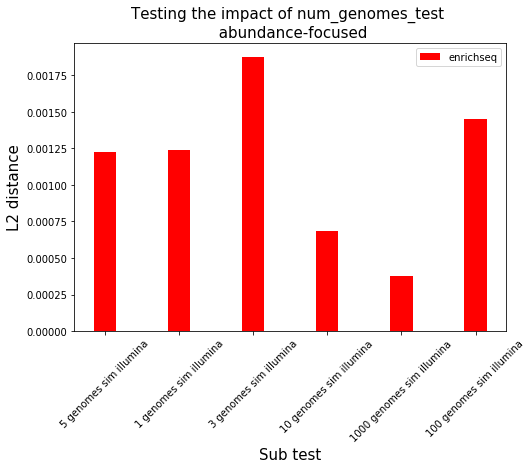

{'5_genomes_sim_illumina': {'enrichseq': <__main__.ResultStruct at 0x2b27ef85fbe0>},
 '1_genomes_sim_illumina': {'enrichseq': <__main__.ResultStruct at 0x2b27f6177630>},
 '3_genomes_sim_illumina': {'enrichseq': <__main__.ResultStruct at 0x2b27f6168cc0>},
 '10_genomes_sim_illumina': {'enrichseq': <__main__.ResultStruct at 0x2b27f61c3eb8>},
 '1000_genomes_sim_illumina': {'enrichseq': <__main__.ResultStruct at 0x2b27f61775f8>},
 '100_genomes_sim_illumina': {'enrichseq': <__main__.ResultStruct at 0x2b27f6168fd0>}}

In [179]:
plot_violin(results, test='num_genomes_test', metric='classification')
plot_violin(results, test='num_genomes_test', metric='abundance')

results['num_genomes_test']

### Number of read mutations

[0 1 2 3]


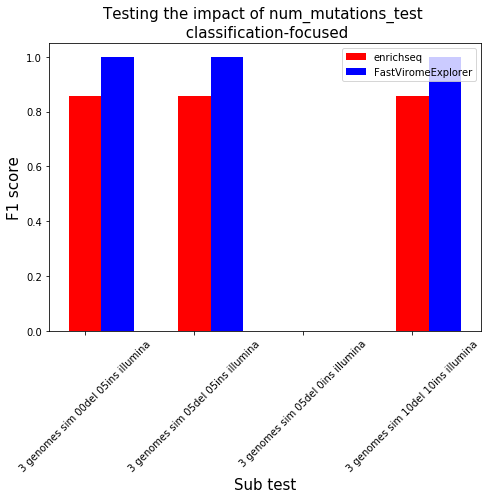

[0 1 2 3]


/curc/sw/anaconda3/2019.07/envs/jupyterlab2/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/curc/sw/anaconda3/2019.07/envs/jupyterlab2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


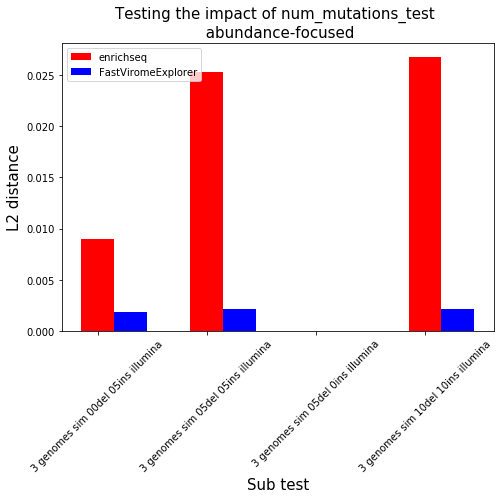

{'3_genomes_sim_00del_05ins_illumina': {'FastViromeExplorer': <__main__.ResultStruct at 0x2b27f6177fd0>,
  'enrichseq': <__main__.ResultStruct at 0x2b27f6177f98>},
 '3_genomes_sim_05del_05ins_illumina': {'FastViromeExplorer': <__main__.ResultStruct at 0x2b27f6177f28>,
  'enrichseq': <__main__.ResultStruct at 0x2b27f6177f60>},
 '3_genomes_sim_05del_0ins_illumina': {'FastViromeExplorer': <__main__.ResultStruct at 0x2b27f6177eb8>,
  'enrichseq': <__main__.ResultStruct at 0x2b27f6177ef0>},
 '3_genomes_sim_10del_10ins_illumina': {'FastViromeExplorer': <__main__.ResultStruct at 0x2b27f6177e80>,
  'enrichseq': <__main__.ResultStruct at 0x2b27f6177e10>}}

In [180]:
plot_violin(results, test='num_mutations_test', metric='classification')
plot_violin(results, test='num_mutations_test', metric='abundance')

results['num_mutations_test']

### Number of reads

[0 1 2 3 4 5 6 7 8 9]


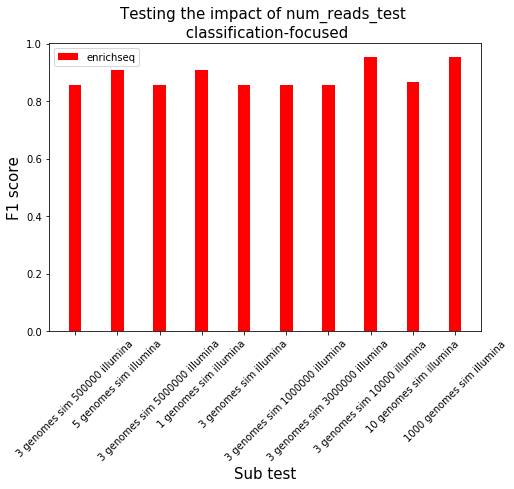

[0 1 2 3 4 5 6 7 8 9]


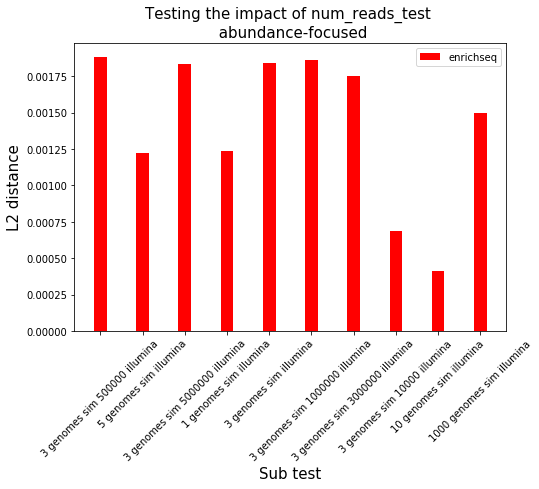

In [181]:
plot_violin(results, test='num_reads_test', metric='classification')
plot_violin(results, test='num_reads_test', metric='abundance')
